In [2]:
!pip install darts statsmodels prophet

In [19]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
%matplotlib inline

from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_pacf, plot_residuals_analysis
from darts.dataprocessing.transformers.boxcox import BoxCox
from statsmodels.tsa.seasonal import seasonal_decompose

#Dataset timeseries
from darts.datasets import AirPassengersDataset, AusBeerDataset, GasRateCO2Dataset
from darts.datasets import HeartRateDataset, IceCreamHeaterDataset, MonthlyMilkDataset
from darts.datasets import SunspotsDataset


In [2]:
df = AirPassengersDataset().load().pd_dataframe()

In [3]:
df

component,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


In [9]:
df = df.reset_index() 
df.columns = ['Month', 'Passengers'] 
df

,Month,Passengers
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0
...,...,...
139,1960-08-01,606.0
140,1960-09-01,508.0
141,1960-10-01,461.0
142,1960-11-01,390.0


In [13]:
df = df.set_index(['Month'])

In [15]:
df

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Passengers  144 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


### Plot time series data

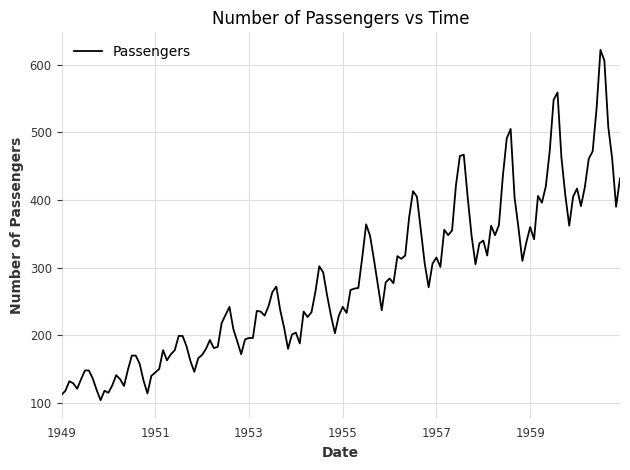

In [17]:
df.plot()
plt.title("Number of Passengers vs Time")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.tight_layout()
plt.show()

### Additive vs Multiplicative Time Series

Multiplicative Decomposition


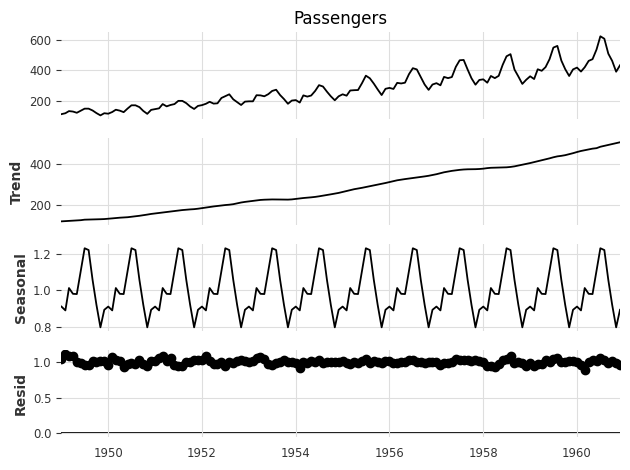

In [21]:
# Multiplicative Decomposition
result_mul = seasonal_decompose(df['Passengers'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df['Passengers'], model='additive', extrapolate_trend='freq')

print('Multiplicative Decomposition')
result_mul.plot()
plt.show()

Additive Decomposition


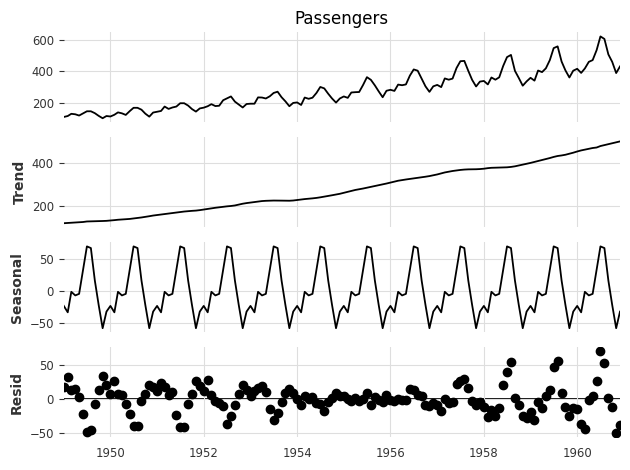

In [22]:
print('Additive Decomposition')
result_add.plot()
plt.show()

If you look closely at the remaining additive decomposition, there are several patterns remaining. However, the multiplicative decomposition looks quite random and that's good. So, multiplicative decomposition is preferred for this particular series.

In [26]:
result_mul.seasonal

Month
1949-01-01    0.911256
1949-02-01    0.890342
1949-03-01    1.012397
1949-04-01    0.980719
1949-05-01    0.979495
                ...   
1960-08-01    1.219640
1960-09-01    1.056262
1960-10-01    0.920694
1960-11-01    0.797882
1960-12-01    0.893580
Name: seasonal, Length: 144, dtype: float64

In [27]:
result_mul.observed

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
              ...  
1960-08-01    606.0
1960-09-01    508.0
1960-10-01    461.0
1960-11-01    390.0
1960-12-01    432.0
Name: Passengers, Length: 144, dtype: float64

In [28]:
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
Month,,,,
1949-01-01,0.911256,118.588481,1.036418,112.0
1949-02-01,0.890342,119.734169,1.106896,118.0
1949-03-01,1.012397,120.879856,1.078621,132.0
1949-04-01,0.980719,122.025544,1.077940,129.0
1949-05-01,0.979495,123.171232,1.002938,121.0


Let's check if seas x trend x resid = actual

In [29]:
df_reconstructed['check_actual'] = df_reconstructed['seas'] * df_reconstructed['trend'] * df_reconstructed['resid']
df_reconstructed

,seas,trend,resid,actual_values,check_actual
Month,,,,,
1949-01-01,0.911256,118.588481,1.036418,112.0,112.0
1949-02-01,0.890342,119.734169,1.106896,118.0,118.0
1949-03-01,1.012397,120.879856,1.078621,132.0,132.0
1949-04-01,0.980719,122.025544,1.077940,129.0,129.0
1949-05-01,0.979495,123.171232,1.002938,121.0,121.0
...,...,...,...,...,...
1960-08-01,1.219640,486.355575,1.021614,606.0,606.0
1960-09-01,1.056262,490.716443,0.980080,508.0,508.0
1960-10-01,0.920694,495.077312,1.011376,461.0,461.0


Using the ADF test to see whether the above time series is stationary or not

In [30]:
from statsmodels.tsa.stattools import adfuller

Multiplicative on df_reconstructed

In [31]:
result = adfuller(df_reconstructed['actual_values'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: 0.8153688792060457
p-value: 0.991880243437641


In [32]:
result

(0.8153688792060457,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

The p value above is 0.99, and that includes a non-stationary time series.

In [33]:
result = adfuller(df_reconstructed['resid'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
p_value_mul = result[1]

ADF Statistic: -7.590190972177456
p-value: 2.5434864627617993e-11


Additive on df_reconstructed

In [34]:
result = adfuller(result_add.resid, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
p_value_additive = result[1]

ADF Statistic: -5.38213906871529
p-value: 3.69240847039606e-06


In [35]:
if p_value_mul < p_value_additive:
    print('our dataset is multiplicative')
else :
    print('our dataset is additive')

our dataset is multiplicative


Focus on actual values for forecasting, as stationary, trend, and residual are incorporated into actual values. The actual ADF value results with a p-value of 0.99 so it is not stationary.

- The remainder of df_reconstructed from result_mul has a p-value < of the p-value in result_add, meaning this dataset is multiplicative.

### Forecasting
1. Naive Seasonal & Naive Drift
2. Auto-Arima
3. Prophet

In [36]:
import time
from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
)
from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_pacf, plot_residuals_analysis
from darts.dataprocessing.transformers.boxcox import BoxCox

In [38]:
#evaluate function for modelling
def evaluate(actual_test, prediction):
    print(f'RMSE: {rmse(actual_test, prediction)}')
    print(f'R2: {r2_score(actual_test, prediction)}')
    print(f'MAPE: {mape(actual_test, prediction)}')

<Axes: xlabel='Month'>

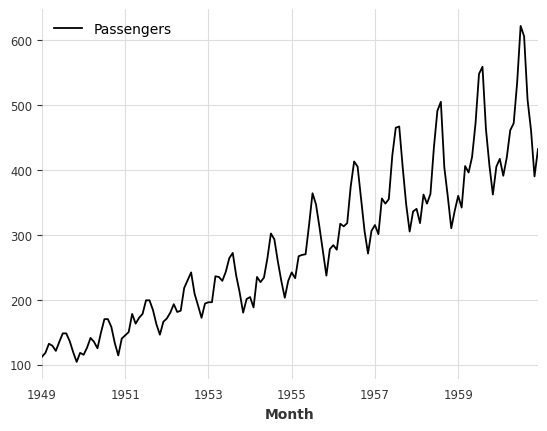

In [40]:
df.plot()

Prepare dataset

In [42]:
data = df.copy()
data.reset_index(inplace=True)

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


convert dataframe into TimeSeries object using sktime library

In [46]:
ts = TimeSeries.from_dataframe(data, time_col = 'Month', value_cols = 'Passengers')
series = ts 
ts

<TimeSeries (DataArray) (Month: 144, component: 1, sample: 1)>
array([[[112.]],

       [[118.]],

       [[132.]],

       [[129.]],

       [[121.]],

       [[135.]],

       [[148.]],

       [[148.]],

       [[136.]],

       [[119.]],

...

       [[419.]],

       [[461.]],

       [[472.]],

       [[535.]],

       [[622.]],

       [[606.]],

       [[508.]],

       [[461.]],

       [[390.]],

       [[432.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1949-01-01 1949-02-01 ... 1960-12-01
  * component  (component) object 'Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='Month'>

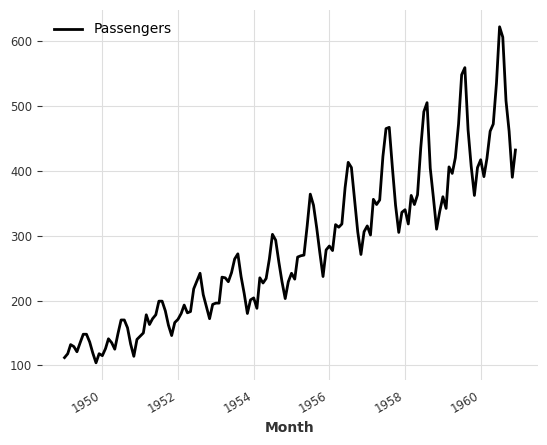

In [47]:
ts.plot()

<Axes: xlabel='Month'>

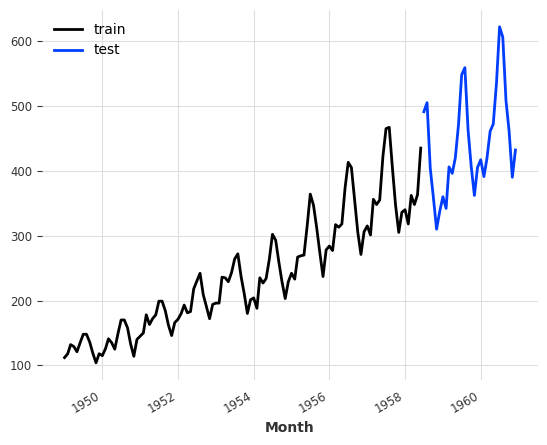

In [48]:
ts_train, ts_test = ts.split_before(0.80)
ts_train.plot(label = 'train')
ts_test.plot(label = 'test')

In [49]:
ts_test

<TimeSeries (DataArray) (Month: 30, component: 1, sample: 1)>
array([[[491.]],

       [[505.]],

       [[404.]],

       [[359.]],

       [[310.]],

       [[337.]],

       [[360.]],

       [[342.]],

       [[406.]],

       [[396.]],

...

       [[419.]],

       [[461.]],

       [[472.]],

       [[535.]],

       [[622.]],

       [[606.]],

       [[508.]],

       [[461.]],

       [[390.]],

       [[432.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1958-07-01 1958-08-01 ... 1960-12-01
  * component  (component) object 'Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [50]:
ts_train

<TimeSeries (DataArray) (Month: 114, component: 1, sample: 1)>
array([[[112.]],

       [[118.]],

       [[132.]],

       [[129.]],

       [[121.]],

       [[135.]],

       [[148.]],

       [[148.]],

       [[136.]],

       [[119.]],

...

       [[404.]],

       [[347.]],

       [[305.]],

       [[336.]],

       [[340.]],

       [[318.]],

       [[362.]],

       [[348.]],

       [[363.]],

       [[435.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1949-01-01 1949-02-01 ... 1958-06-01
  * component  (component) object 'Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Training forecasting models and making predictions

### Naive Seasonal and Naive Drift

Because the time span in our data is 12 periods for seasonality, then K = 12. So, this model only copies the last 12 values in the `train` series, and repeats them continuously.

RMSE: 76.58285273697588
R2: 0.019864745925108895
MAPE: 14.043967381244526
Fitting the time series model takes 0.0 seconds.


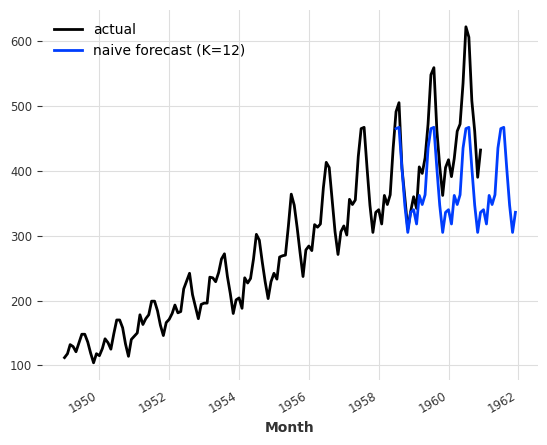

In [52]:
seasonal_model = NaiveSeasonal(K=12)
start = time.time() 
seasonal_model.fit(ts_train) #fitting naive seasonal
end = time.time()
seasonal_forecast = seasonal_model.predict(42)

series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")
evaluate(ts_test, seasonal_forecast)

print('Fitting the time series model takes', end-start, 'seconds.')

<Axes: xlabel='Month'>

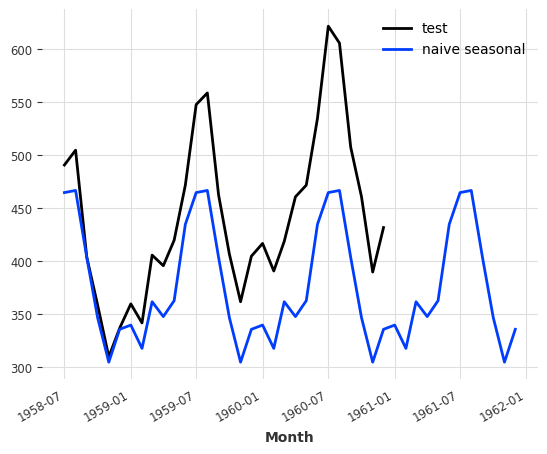

In [53]:
ts_test.plot(label = 'test')
seasonal_forecast.plot(label = 'naive seasonal') #check for data test

This is better, but we are still missing the trend. Fortunately, there is also another naive baseline model capturing the trend, which is called NaiveDrift. This model simply produces linear predictions, with a slope that is determined by the first and last values of the training set

### Naive Drift

RMSE: 30.899586048869487
R2: 0.840438447476271
MAPE: 4.832692851918194
Fitting the time series model takes 0.0 seconds.


<Axes: xlabel='Month'>

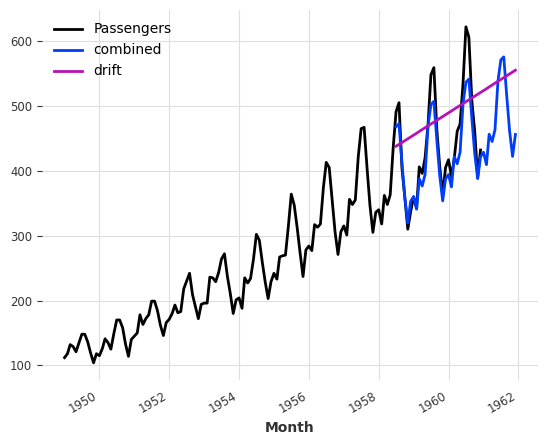

In [54]:
drift_model = NaiveDrift()
start = time.time()
drift_model.fit(ts_train) #fitting naive drift
end = time.time()
drift_forecast = drift_model.predict(42)

combined_forecast = drift_forecast + seasonal_forecast - ts_train.last_value()
evaluate(ts_test, combined_forecast)

print('Fitting the time series model takes', end - start, 'seconds.')
series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

This model adapts a naive drift model, and adds its estimates to the previously held seasonal estimates. The model also subtracts the last value of the training set from the result, so that the resulting combined estimate starts with the correct offset.

### ARIMA

RMSE: 93.28497893267158
R2: -0.4542744233545539
MAPE: 13.981802037937943
Fitting the time series model takes 2.165026903152466 seconds.


<Axes: xlabel='Month'>

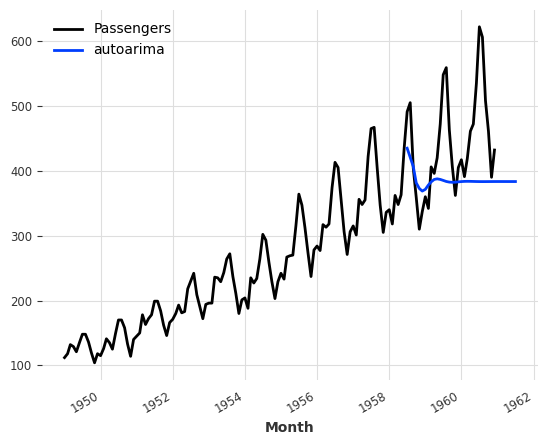

In [55]:
autoarima = AutoARIMA()
start = time.time()
autoarima.fit(ts_train)
end = time.time()
autoarima_forecast = autoarima.predict(37)

evaluate(ts_test, autoarima_forecast)

print('Fitting the time series model takes', end - start, 'seconds.')
series.plot()
autoarima_forecast.plot(label = 'autoarima')

The results of the ARIMA model are bad, so several steps are needed, namely determining the optimal amount of differentiation to make the time series stationary so that it can be modeled using the ARIMA model.

In [56]:
import pmdarima as pmd
import statsmodels.api as sm
from scipy.stats import normaltest
# https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ndiffs.html
def arima_diff(timeseries, alpha):
    n_kpss = pmd.arima.ndiffs(timeseries.pd_dataframe(), alpha = alpha, test = 'kpss', max_d = 2)
    n_adf = pmd.arima.ndiffs(timeseries.pd_dataframe(), alpha = alpha, test = 'adf', max_d = 2)
    return max(n_adf, n_kpss)

In [57]:
n_diff = arima_diff(ts_train, alpha = 0.05)
print(n_diff)

1


<Axes: xlabel='Month'>

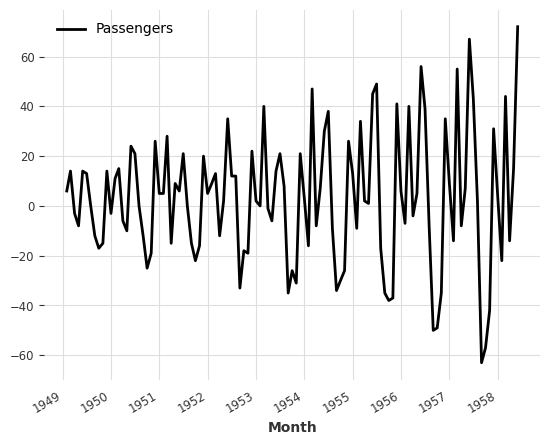

In [58]:
ts_train.diff(n = 1).plot()

In [59]:
n_diff

1

In [70]:
new_autoarima = AutoARIMA(d=1, 
                          max_d=1,
                          D=1, 
                          m=12, # seasonality
                          seasonal=True, # Our time series is seasonal
                          max_order=10, 
                          stationary=False, # This time series is not stationary
                          suppress_warnings=True, 
                          error_action = 'trace', trace = True, information_criterion="bic")

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,1,1)[12]             : BIC=inf, Time=0.67 sec
 ARIMA(0,1,0)(0,1,0)[12]             : BIC=752.282, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : BIC=754.839, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : BIC=755.515, Time=0.07 sec
 ARIMA(0,1,0)(1,1,0)[12]             : BIC=753.808, Time=0.05 sec
 ARIMA(0,1,0)(0,1,1)[12]             : BIC=753.906, Time=0.07 sec
 ARIMA(0,1,0)(1,1,1)[12]             : BIC=758.411, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[12]             : BIC=752.229, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : BIC=755.146, Time=0.10 sec
 ARIMA(1,1,0)(1,1,1)[12]             : BIC=759.234, Time=0.15 sec
 ARIMA(2,1,0)(0,1,0)[12]             : BIC=756.321, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : BIC=755.612, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12]             : BIC=752.696, Time=0.03 sec
 ARIMA(2,1,1)(0,1,0)[12]             : BIC=760.219, Time=0.05 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   

<Axes: xlabel='Month'>

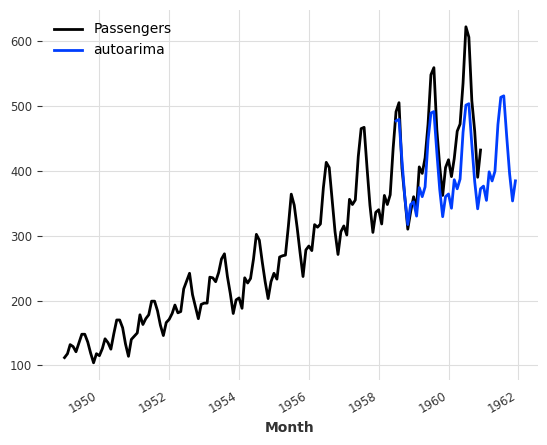

In [71]:
start = time.time()
new_autoarima.fit(ts_train) #fitting model auto arima
end = time.time()
# https://alkaline--ml-com.translate.goog/pmdarima/modules/generated/pmdarima.arima.auto_arima.html?_x_tr_sl=en&_x_tr_tl=id&_x_tr_hl=id&_x_tr_pto=tc

new_autoarima_forecast = new_autoarima.predict(42)
evaluate(ts_test, new_autoarima_forecast)


print('Fitting the time series model takes', end - start, 'seconds.')
series.plot()
new_autoarima_forecast.plot(label = 'autoarima')

Fitting the time series model takes 1.5004863739013672 seconds.


<Axes: xlabel='Month'>

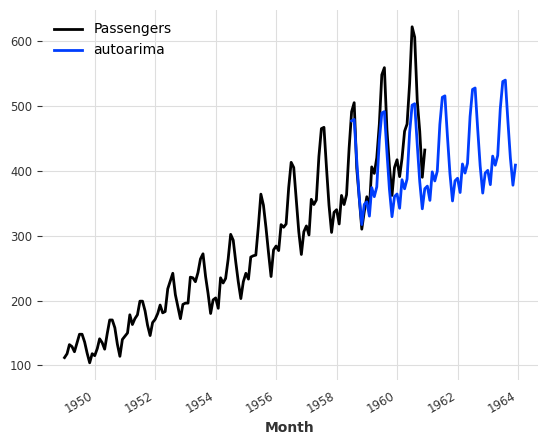

In [72]:
new_autoarima_forecast = new_autoarima.predict(66) 

print('Fitting the time series model takes', end - start, 'seconds.')
series.plot()
new_autoarima_forecast.plot(label = 'autoarima')

### Prophet

09:02:02 - cmdstanpy - INFO - Chain [1] start processing
09:02:03 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 41.91995305300055
R2: 0.7063266713516879
MAPE: 7.589103858058372
Fitting the time series model takes 0.9449915885925293 seconds.


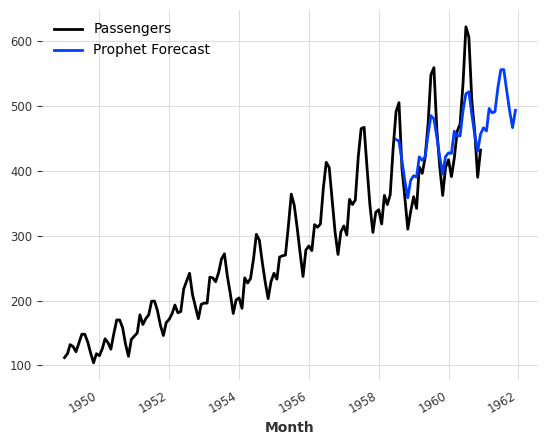

In [75]:
prop = Prophet()
start = time.time()
prop.fit(ts_train) #fit modelling using prophet
end = time.time()
prop_forecast = prop.predict(42)

series.plot()
prop_forecast.plot(label = 'Prophet Forecast')

evaluate(ts_test, prop_forecast)

print('Fitting the time series model takes', end - start, 'seconds.')

RMSE: 41.91995305300055
R2: 0.7063266713516879
MAPE: 7.589103858058372
Fitting the time series model takes 0.9449915885925293 seconds.


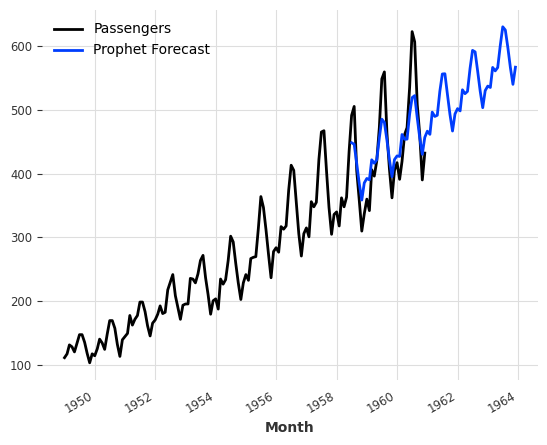

In [76]:
prop_forecast = prop.predict(66) 

series.plot()
prop_forecast.plot(label = 'Prophet Forecast')

evaluate(ts_test, prop_forecast)

print('Fitting the time series model takes', end - start, 'seconds.')

### Best Model

From the results above, the Naive Drift Naive Seasonal model has a higher Rsquare value than the other 2 models and smaller MAPE and RMSE values than the ARIMA and Prophet models.